In [1]:
import pandas as pd
import h5py
from tqdm import tqdm
import h5py
import numpy as np

# Load Data

In [2]:
filename = '../data/9606.protein.sequence.embeddings.v12.0.h5'

with h5py.File(filename, 'r') as f:
    meta_keys = f['metadata'].attrs.keys()
    for key in meta_keys:
        print(key, f['metadata'].attrs[key])
    
    embedding = f['embeddings'][:]
    proteins = f['proteins'][:]
    proteins = [p.decode('utf-8') for p in proteins]

# Create DataFrame with one column containing the vector arrays
network_vector_df = pd.DataFrame({
    'embedding_vector': [np.array(vec) for vec in embedding]
}, index=proteins)

enrichment_df = pd.read_csv('../data/9606.protein.enrichment.terms.v12.0.txt.gz', 
                          sep='\t',  
                          compression='gzip')

enrichment_df.set_index('#string_protein_id', inplace=True)

go_categories = [
    'Biological Process (Gene Ontology)',
]

go_enrichment_df = enrichment_df[enrichment_df['category'].isin(go_categories)]


embedding_dim 1024
n_proteins 19699
precision 16


# Combine Data

In [3]:
# First create mapping of GO descriptions for proteins that have them
go_descriptions = go_enrichment_df.groupby(level=0)['description'].agg(lambda x: list(set(x)))

# Calculate frequency of each GO term (counting once per protein)
term_frequencies = {}
total_proteins = len(go_descriptions)
for terms in go_descriptions:
    unique_terms = set(terms)
    for term in unique_terms:
        term_frequencies[term] = term_frequencies.get(term, 0) + 1

# Convert to percentages
term_percentages = {term: count/total_proteins for term, count in term_frequencies.items()}

# Find terms that appear in more than 5% of proteins
common_terms = {term for term, percentage in term_percentages.items() if percentage > 0.005}

# Filter out common terms
def filter_common_terms(terms):
    return [term for term in terms if term not in common_terms]

# Apply filtering
filtered_go_descriptions = go_descriptions.apply(filter_common_terms)

# Create binary vectors for remaining terms
all_go_terms = sorted(set(term for terms in filtered_go_descriptions for term in terms))
term_to_idx = {term: idx for idx, term in enumerate(all_go_terms)}

def terms_to_binary_vector(terms):
    vector = [0] * len(all_go_terms)
    if isinstance(terms, (list, set, tuple)):
        for term in terms:
            if term in term_to_idx:
                vector[term_to_idx[term]] = 1
    return vector

# Create vectors for all proteins in network_vector_df
all_protein_vectors = {}
for protein in network_vector_df.index:
    if protein in filtered_go_descriptions:
        all_protein_vectors[protein] = terms_to_binary_vector(filtered_go_descriptions[protein])
    else:
        all_protein_vectors[protein] = [0] * len(all_go_terms)

# Create final DataFrame with all proteins from embedding dataset
final_df = pd.DataFrame({
    'go_vector': list(all_protein_vectors.values())
}, index=list(all_protein_vectors.keys()))

# Print summary statistics
print("Dataset Statistics:")
print(f"Total number of proteins: {len(final_df)}")
print(f"Total number of GO terms after filtering: {len(all_go_terms)}")
print(f"Number of common terms filtered out (>.5%): {len(common_terms)}")

# Calculate how many proteins have no terms
empty_vectors = sum(1 for vec in final_df['go_vector'] if sum(vec) == 0)
print(f"\nProteins with no GO terms: {empty_vectors} ({(empty_vectors/len(final_df))*100:.1f}%)")
print(f"- From missing GO annotations: {len(network_vector_df.index) - len(go_descriptions)}")
print(f"- From filtering: {empty_vectors - (len(network_vector_df.index) - len(go_descriptions))}")

# Calculate distribution of GO terms per protein
terms_per_protein = [sum(vec) for vec in final_df['go_vector']]
print("\nGO terms per protein distribution:")
print(f"Mean: {np.mean(terms_per_protein):.1f}")
print(f"Median: {np.median(terms_per_protein):.1f}")
print(f"Min: {min(terms_per_protein)}")
print(f"Max: {max(terms_per_protein)}")

# Calculate most common remaining terms
term_counts = np.sum([vec for vec in final_df['go_vector']], axis=0)
top_terms_idx = np.argsort(term_counts)[-5:][::-1]
print("\nTop 5 most common remaining terms:")
for idx in top_terms_idx:
    term = [k for k, v in term_to_idx.items() if v == idx][0]
    count = term_counts[idx]
    percentage = (count/len(final_df))*100
    print(f"{term}: {count} proteins ({percentage:.1f}%)")

Dataset Statistics:
Total number of proteins: 19699
Total number of GO terms after filtering: 13889
Number of common terms filtered out (>.5%): 1798

Proteins with no GO terms: 6466 (32.8%)
- From missing GO annotations: 2434
- From filtering: 4032

GO terms per protein distribution:
Mean: 8.7
Median: 3.0
Min: 0
Max: 332

Top 5 most common remaining terms:
Regulation of transcription elongation from RNA polymerase II promoter: 86 proteins (0.4%)
Negative regulation of transporter activity: 86 proteins (0.4%)
Regulation of viral genome replication: 86 proteins (0.4%)
Positive regulation of lipid biosynthetic process: 86 proteins (0.4%)
Transport across blood-brain barrier: 86 proteins (0.4%)


In [4]:
final_df

,go_vector
9606.ENSP00000000233,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9606.ENSP00000000412,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9606.ENSP00000001008,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9606.ENSP00000001146,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9606.ENSP00000002125,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...
9606.ENSP00000501254,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9606.ENSP00000501259,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9606.ENSP00000501265,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9606.ENSP00000501277,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


Prepare Data

In [5]:
# Convert list of binary vectors to numpy matrix
go_matrix = np.vstack(final_df['go_vector'])

# Print shape and basic stats
print(f"Matrix shape: {go_matrix.shape}")  # Should be (19699, n_GO_terms)
print(f"Matrix dtype: {go_matrix.dtype}")
print(f"Total number of 1s: {np.sum(go_matrix)}")
print(f"Sparsity: {1 - (np.sum(go_matrix)/(go_matrix.shape[0] * go_matrix.shape[1])):.3f}")  # Fraction of zeros

Matrix shape: (19699, 13889)
Matrix dtype: int64
Total number of 1s: 170870
Sparsity: 0.999


In [6]:
# Take a random sample of proteins for estimation
sample_size = 1000  # or whatever size gives good balance of speed vs accuracy
np.random.seed(42)
sample_indices = np.random.choice(go_matrix.shape[0], sample_size, replace=False)
sample_matrix = go_matrix[sample_indices]

# Calculate shared terms for just this sample
sample_shared = sample_matrix @ sample_matrix.T
sample_pairs_with_shared = np.sum(np.triu(sample_shared > 0, k=1))

# Calculate statistics from sample
sample_possible_pairs = (sample_size * (sample_size - 1)) // 2
sharing_percentage = (sample_pairs_with_shared/sample_possible_pairs)*100

# Extrapolate to full dataset
total_proteins = go_matrix.shape[0]
total_possible_pairs = (total_proteins * (total_proteins - 1)) // 2
estimated_total_pairs = int((sharing_percentage/100) * total_possible_pairs)

print(f"Estimated from {sample_size} protein sample:")
print(f"Estimated proteins sharing terms: {estimated_total_pairs:,} pairs")
print(f"Total possible pairs: {total_possible_pairs:,}")
print(f"Estimated percentage sharing terms: {sharing_percentage:.1f}%")

Estimated from 1000 protein sample:
Estimated proteins sharing terms: 1,501,629 pairs
Total possible pairs: 194,015,451
Estimated percentage sharing terms: 0.8%


Generate Test and Train

In [8]:
import numpy as np
from tqdm import tqdm  # for progress bars

def generate_random_pair(n_proteins):
    while True:
        i = np.random.randint(0, n_proteins)
        j = np.random.randint(0, n_proteins)
        if i < j:  # ensure i < j to avoid duplicates
            return (i, j)

# First generate 100k pairs of each type
n_pairs = 100_000
n_proteins = go_matrix.shape[0]

print("Generating initial pairs...")
pairs_set = set()
nonpairs_set = set()

with tqdm(total=n_pairs*2) as pbar:
    while len(pairs_set) < n_pairs or len(nonpairs_set) < n_pairs:
        i, j = generate_random_pair(n_proteins)
        
        if (i, j) not in pairs_set and (i, j) not in nonpairs_set:
            if np.any(go_matrix[i] & go_matrix[j]):
                if len(pairs_set) < n_pairs:
                    pairs_set.add((i, j))
                    pbar.update(1)
            else:
                if len(nonpairs_set) < n_pairs:
                    nonpairs_set.add((i, j))
                    pbar.update(1)

# Convert to lists
pairs = list(pairs_set)
nonpairs = list(nonpairs_set)



Generating initial pairs...


100%|██████████| 200000/200000 [04:42<00:00, 706.88it/s] 


In [11]:
# Randomly select 0.5% for eval
eval_size = int(0.005 * n_pairs)
eval_indices = np.random.choice(n_pairs, size=eval_size, replace=False)

eval_pairs = [pairs[i] for i in eval_indices]
eval_nonpairs = [nonpairs[i] for i in eval_indices]

# Get proteins used in eval set
eval_proteins = set()
for i, j in eval_pairs + eval_nonpairs:
    eval_proteins.add(i)
    eval_proteins.add(j)

# Filter remaining pairs to remove any traces of eval proteins
remaining_pairs = []
remaining_nonpairs = []

for idx in range(n_pairs):
    if idx not in eval_indices:
        i, j = pairs[idx]
        if i not in eval_proteins and j not in eval_proteins:
            remaining_pairs.append((i, j))
            
        i, j = nonpairs[idx]
        if i not in eval_proteins and j not in eval_proteins:
            remaining_nonpairs.append((i, j))

# Random 80-20 split on remaining data
train_size = int(0.8 * len(remaining_pairs))

np.random.shuffle(remaining_pairs)
np.random.shuffle(remaining_nonpairs)

train_pairs = remaining_pairs[:train_size]
test_pairs = remaining_pairs[train_size:]
train_nonpairs = remaining_nonpairs[:train_size]

test_nonpairs = remaining_nonpairs[train_size:]
test_size = len(test_pairs)  # Use number of positive test pairs as reference
test_nonpairs = test_nonpairs[:test_size]  # Trim negative test pairs to match


# Print statistics
print("\nDataset Statistics:")
print(f"Eval positive pairs: {len(eval_pairs)}")
print(f"Eval negative pairs: {len(eval_nonpairs)}")
print(f"Train positive pairs: {len(train_pairs)}")
print(f"Train negative pairs: {len(train_nonpairs)}")
print(f"Test positive pairs: {len(test_pairs)}")
print(f"Test negative pairs: {len(test_nonpairs)}")

# Store in dictionaries
train_data = {
    'pairs': train_pairs,
    'nonpairs': train_nonpairs
}

eval_data = {
    'pairs': eval_pairs,
    'nonpairs': eval_nonpairs
}

test_data = {
    'pairs': test_pairs,
    'nonpairs': test_nonpairs
}


Dataset Statistics:
Eval positive pairs: 500
Eval negative pairs: 500
Train positive pairs: 51465
Train negative pairs: 51465
Test positive pairs: 12867
Test negative pairs: 12867


Model Train

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score
import numpy as np
# First prepare our data
def prepare_data(pairs, nonpairs, network_vector_df):
    # Convert all pairs to labels and indices
    all_pairs = [(i, j, 1) for i, j in pairs] + [(i, j, 0) for i, j in nonpairs]
    
    # Convert embeddings to torch tensor
    embeddings = torch.tensor(np.vstack(network_vector_df['embedding_vector'].values), dtype=torch.float32)
    
    return all_pairs, embeddings


# Dataset class
class PairDataset(Dataset):
    def __init__(self, pairs, embeddings):
        self.pairs = pairs
        self.embeddings = embeddings
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        i, j, label = self.pairs[idx]
        return {
            'emb1': self.embeddings[i],
            'emb2': self.embeddings[j],
            'label': torch.tensor(label, dtype=torch.float32)
        }
# at 1% cut off
# Simple element-wise weight model with sigmoid got f1 around 68, at 0.5% around 70
# with a single nn layer(withresidual connection and dropout)-74. more layers just overfits 

# Simple element-wise weight model with sigmoid
class EmbeddingWeights(nn.Module):
    def __init__(self, embedding_dim=1024):  # Fixed method name
        super().__init__()  # Fixed super() call
        self.weights = nn.Parameter(torch.randn(embedding_dim))
        self.sigmoid = nn.Sigmoid()

    def forward(self, emb1, emb2):
        # Apply weights to embeddings
        weighted_emb1 = emb1 * self.weights
        weighted_emb2 = emb2 * self.weights

        # Compute cosine similarity and apply sigmoid
        cos_sim = nn.functional.cosine_similarity(weighted_emb1, weighted_emb2, dim=1)
        return self.sigmoid(cos_sim)

def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0
    criterion = nn.BCELoss()
    
    with torch.no_grad():
        for batch in data_loader:
            output = model(batch['emb1'], batch['emb2'])
            loss = criterion(output, batch['label'])
            total_loss += loss.item()
            
            predictions = (output > 0.5).float()
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(batch['label'].cpu().numpy())
    
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    f1 = f1_score(all_labels, all_preds)
    avg_loss = total_loss / len(data_loader)
    
    return accuracy, f1, avg_loss

def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=1e-4):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.BCELoss()
    
    best_f1 = 0
    best_model = None
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            output = model(batch['emb1'], batch['emb2'])
            loss = criterion(output, batch['label'])
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_acc, train_f1, train_loss = evaluate_model(model, train_loader)
        val_acc, val_f1, val_loss = evaluate_model(model, val_loader)
        
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_model = model.state_dict().copy()
        
        print(f'Epoch {epoch+1}:')
        print(f'Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}')
        print(f'Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}\n')
    
    model.load_state_dict(best_model)
    return model

# Prepare data and train
train_pairs_data, embeddings = prepare_data(train_pairs, train_nonpairs, network_vector_df)
test_pairs_data, _ = prepare_data(test_pairs, test_nonpairs, network_vector_df)

train_dataset = PairDataset(train_pairs_data, embeddings)
test_dataset = PairDataset(test_pairs_data, embeddings)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = EmbeddingWeights()

In [17]:
model = train_model(model, train_loader, test_loader, num_epochs=10) # this requied more training than network, about epochs.

Epoch 1:
Train - Loss: 0.6669, Acc: 0.5884, F1: 0.6858
Val   - Loss: 0.6672, Acc: 0.5867, F1: 0.6847

Epoch 2:
Train - Loss: 0.6666, Acc: 0.5900, F1: 0.6862
Val   - Loss: 0.6669, Acc: 0.5878, F1: 0.6847

Epoch 3:
Train - Loss: 0.6663, Acc: 0.5913, F1: 0.6865
Val   - Loss: 0.6666, Acc: 0.5884, F1: 0.6845

Epoch 4:
Train - Loss: 0.6660, Acc: 0.5923, F1: 0.6866
Val   - Loss: 0.6663, Acc: 0.5903, F1: 0.6852

Epoch 5:
Train - Loss: 0.6658, Acc: 0.5939, F1: 0.6871
Val   - Loss: 0.6660, Acc: 0.5908, F1: 0.6849

Epoch 6:
Train - Loss: 0.6655, Acc: 0.5948, F1: 0.6872
Val   - Loss: 0.6658, Acc: 0.5919, F1: 0.6852

Epoch 7:
Train - Loss: 0.6652, Acc: 0.5958, F1: 0.6874
Val   - Loss: 0.6655, Acc: 0.5928, F1: 0.6853

Epoch 8:
Train - Loss: 0.6650, Acc: 0.5966, F1: 0.6876
Val   - Loss: 0.6653, Acc: 0.5937, F1: 0.6855

Epoch 9:
Train - Loss: 0.6648, Acc: 0.5972, F1: 0.6875
Val   - Loss: 0.6651, Acc: 0.5942, F1: 0.6855

Epoch 10:
Train - Loss: 0.6646, Acc: 0.5980, F1: 0.6877
Val   - Loss: 0.6649, Acc:

In [18]:
test_acc, test_f1, test_loss = evaluate_model(model, test_loader)
print("\nFinal Test Results:")
print(f"Accuracy: {test_acc:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print(f"Loss: {test_loss:.4f}")


Final Test Results:
Accuracy: 0.5949
F1 Score: 0.6857
Loss: 0.6649


In [20]:
# Prepare evaluation data
eval_pairs_data, _ = prepare_data(eval_pairs, eval_nonpairs, network_vector_df)
eval_dataset = PairDataset(eval_pairs_data, embeddings)
eval_loader = DataLoader(eval_dataset, batch_size=32, shuffle=False)

# Run evaluation
eval_acc, eval_f1, eval_loss = evaluate_model(model, eval_loader)
print(f'Evaluation Results:')
print(f'Accuracy: {eval_acc:.4f}')
print(f'F1 Score: {eval_f1:.4f}')
print(f'Loss: {eval_loss:.4f}')

Evaluation Results:
Accuracy: 0.5890
F1 Score: 0.6792
Loss: 0.6672


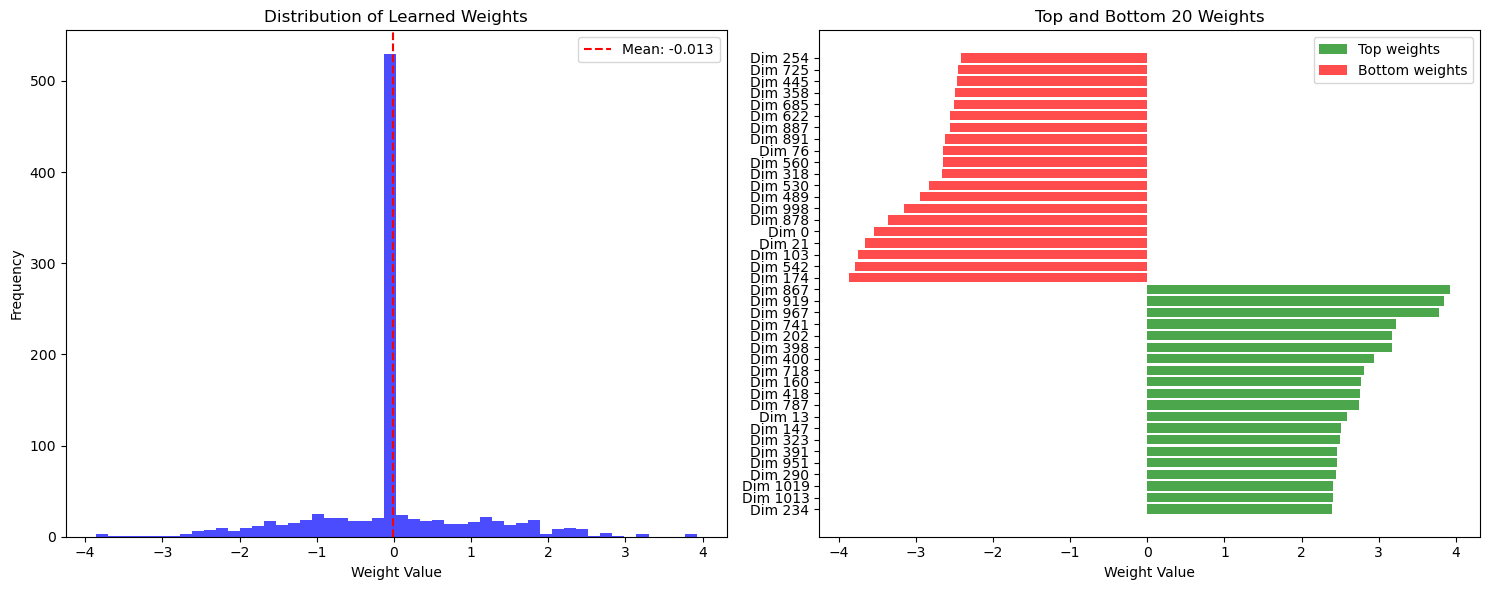


Weight Statistics:
Mean: -0.0134
Std: 1.0072
Min: -3.8600 (Dimension 174)
Max: 3.9212 (Dimension 234)

Number of weights > 0.1: 237
Number of weights < 0.1: 787
Number of weights ≈ 0 (|w| < 0.1): 538


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get the learned weights
learned_weights = model.weights.detach().numpy()


# Sort weights by magnitude for better visualization
sorted_indices = np.argsort(learned_weights)
sorted_weights = learned_weights[sorted_indices]

# Create figure
plt.figure(figsize=(15, 6))

# Main weight distribution plot
plt.subplot(1, 2, 1)
plt.hist(learned_weights, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Learned Weights')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.axvline(x=learned_weights.mean(), color='red', linestyle='--', label=f'Mean: {learned_weights.mean():.3f}')
plt.legend()

# Top/bottom weights plot
plt.subplot(1, 2, 2)
n_top = 20  # number of top/bottom weights to show

# Plot top and bottom weights
plt.barh(range(n_top), sorted_weights[-n_top:], color='green', alpha=0.7, label='Top weights')
plt.barh(range(n_top, 2*n_top), sorted_weights[:n_top], color='red', alpha=0.7, label='Bottom weights')

plt.yticks(range(2*n_top), 
          [f'Dim {sorted_indices[-i-1]}' for i in range(n_top)] + 
          [f'Dim {sorted_indices[i]}' for i in range(n_top)])
plt.title(f'Top and Bottom {n_top} Weights')
plt.xlabel('Weight Value')
plt.legend()

plt.tight_layout()
plt.show()

# Print some summary statistics
print("\nWeight Statistics:")
print(f"Mean: {learned_weights.mean():.4f}")
print(f"Std: {learned_weights.std():.4f}")
print(f"Min: {learned_weights.min():.4f} (Dimension {sorted_indices[0]})")
print(f"Max: {learned_weights.max():.4f} (Dimension {sorted_indices[-1]})")

# Count weights approximately equal to 0
epsilon = 0.1  # You can adjust this threshold as needed
print(f"\nNumber of weights > {epsilon}: {np.sum(learned_weights > epsilon)}")
print(f"Number of weights < {epsilon}: {np.sum(learned_weights < epsilon)}")


zero_weights = np.sum(np.abs(learned_weights) < epsilon)
print(f"Number of weights ≈ 0 (|w| < {epsilon}): {zero_weights}")

In [22]:
np.save('learned_cosine_weights_sequence.npy', learned_weights)

Baseline un-weighted cosine sim score.

In [23]:
def evaluate_cosine_baseline(pairs_data, embeddings, weights=None):
    sigmoid = nn.Sigmoid()
    all_preds = []
    all_labels = []
    
    for i, j, label in pairs_data:
        emb1 = embeddings[i].unsqueeze(0)
        emb2 = embeddings[j].unsqueeze(0)
        
        # Apply weights if provided
        if weights is not None:
            emb1 = emb1 * weights
            emb2 = emb2 * weights
        
        # Calculate cosine similarity and apply sigmoid
        cos_sim = nn.functional.cosine_similarity(emb1, emb2)
        output = sigmoid(cos_sim)
        
        # Convert to binary prediction
        pred = (output > 0.5).float()
        
        all_preds.append(pred.item())
        all_labels.append(label)
    
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    f1 = f1_score(all_labels, all_preds)
    
    return accuracy, f1

# Test unweighted version
train_acc, train_f1 = evaluate_cosine_baseline(train_pairs_data, embeddings)
test_acc, test_f1 = evaluate_cosine_baseline(test_pairs_data, embeddings)

print(f'Unweighted Baseline Train - Acc: {train_acc:.4f}, F1: {train_f1:.4f}')
print(f'Unweighted Baseline Test  - Acc: {test_acc:.4f}, F1: {test_f1:.4f}')

Unweighted Baseline Train - Acc: 0.5000, F1: 0.6667
Unweighted Baseline Test  - Acc: 0.5000, F1: 0.6667


In [24]:
# This completely removes dims with less than threshold magnitude weight
def evaluate_cosine_baseline_with_threshold(pairs_data, embeddings, weights=None, threshold=1):
    sigmoid = nn.Sigmoid()
    all_preds = []
    all_labels = []
    
    # If weights provided, create mask for significant dimensions
    if weights is not None:
        significant_dims = torch.abs(weights) >= threshold
        # Filter embeddings and weights to only keep significant dimensions
        filtered_weights = weights[significant_dims]
    
    for i, j, label in pairs_data:
        emb1 = embeddings[i].unsqueeze(0)
        emb2 = embeddings[j].unsqueeze(0)
        
        if weights is not None:
            # Filter to significant dimensions
            emb1 = emb1[:, significant_dims]
            emb2 = emb2[:, significant_dims]
            # Apply remaining weights
            emb1 = emb1 * filtered_weights
            emb2 = emb2 * filtered_weights
        
        # Calculate cosine similarity and apply sigmoid
        cos_sim = nn.functional.cosine_similarity(emb1, emb2)
        output = sigmoid(cos_sim)
        
        pred = (output > 0.5).float()
        all_preds.append(pred.item())
        all_labels.append(label)
    
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    f1 = f1_score(all_labels, all_preds)
    
    # Calculate how many dimensions were kept
    if weights is not None:
        dims_kept = significant_dims.sum().item()
        dims_total = len(weights)
        print(f'Dimensions kept: {dims_kept}/{dims_total} ({(dims_kept/dims_total)*100:.1f}%)')
    
    return accuracy, f1

# Test unweighted version
train_acc, train_f1 = evaluate_cosine_baseline_with_threshold(train_pairs_data, embeddings, torch.tensor(learned_weights))
test_acc, test_f1 = evaluate_cosine_baseline_with_threshold(test_pairs_data, embeddings, torch.tensor(learned_weights))

print(f'Unweighted Baseline Train - Acc: {train_acc:.4f}, F1: {train_f1:.4f}')
print(f'Unweighted Baseline Test  - Acc: {test_acc:.4f}, F1: {test_f1:.4f}')



Dimensions kept: 272/1024 (26.6%)
Dimensions kept: 272/1024 (26.6%)
Unweighted Baseline Train - Acc: 0.5995, F1: 0.6872
Unweighted Baseline Test  - Acc: 0.5963, F1: 0.6852


Neural Representation Instead

In [25]:
class EmbeddingNN(nn.Module):
    def __init__(self, input_dim, layer_sizes):
        super().__init__()
        
        # Build layers based on input list
        layers = []
        current_dim = input_dim
        
        # If single layer, just do direct projection
        if len(layer_sizes) == 1:
            layers.append(nn.Linear(current_dim, layer_sizes[0]))
        # If multiple layers, add ReLU between them
        else:
            for size in layer_sizes[:-1]:
                layers.extend([
                    nn.Linear(current_dim, size),
                    nn.ReLU()
                ])
                current_dim = size
            # Add final projection layer
            layers.append(nn.Linear(current_dim, layer_sizes[-1]))
        
        self.projection = nn.Sequential(*layers)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, emb1, emb2):
        proj1 = self.projection(emb1)
        proj2 = self.projection(emb2)
        
        cos_sim = nn.functional.cosine_similarity(proj1, proj2, dim=1)
        return self.sigmoid(cos_sim)

In [33]:
modelNN = EmbeddingNN(input_dim=1024, layer_sizes=[5])

In [35]:
modelNN = train_model(modelNN, train_loader, test_loader, num_epochs=5, learning_rate=1e-4)

Epoch 1:
Train - Loss: 0.6050, Acc: 0.6903, F1: 0.7455
Val   - Loss: 0.6148, Acc: 0.6720, F1: 0.7319

Epoch 2:
Train - Loss: 0.6037, Acc: 0.6929, F1: 0.7463
Val   - Loss: 0.6146, Acc: 0.6734, F1: 0.7316

Epoch 3:
Train - Loss: 0.6025, Acc: 0.6938, F1: 0.7475
Val   - Loss: 0.6137, Acc: 0.6752, F1: 0.7336

Epoch 4:
Train - Loss: 0.6020, Acc: 0.6938, F1: 0.7481
Val   - Loss: 0.6146, Acc: 0.6722, F1: 0.7325

Epoch 5:
Train - Loss: 0.6015, Acc: 0.6963, F1: 0.7473
Val   - Loss: 0.6145, Acc: 0.6730, F1: 0.7305



In [36]:
# Prepare evaluation data
eval_pairs_data, _ = prepare_data(eval_pairs, eval_nonpairs, network_vector_df)
eval_dataset = PairDataset(eval_pairs_data, embeddings)
eval_loader = DataLoader(eval_dataset, batch_size=32, shuffle=False)

# Run evaluation
eval_acc, eval_f1, eval_loss = evaluate_model(modelNN, eval_loader)
print(f'Evaluation Results:')
print(f'Accuracy: {eval_acc:.4f}')
print(f'F1 Score: {eval_f1:.4f}')
print(f'Loss: {eval_loss:.4f}')

Evaluation Results:
Accuracy: 0.6500
F1 Score: 0.7112
Loss: 0.6282


In [37]:
torch.save(modelNN, 'neural_rep_sequence.pt')